In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
data_dir="gdrive/MyDrive/age_gender.csv"
raw_df = pd.read_csv(data_dir)
raw_df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [ ]:
raw_df.drop('img_name',axis=1,inplace=True)

In [ ]:
## Converting pixels into numpy array
raw_df['pixels']=raw_df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))
raw_df.head()

,age,ethnicity,gender,pixels
0,1,2,0,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


In [ ]:
raw_df['pixels'] = raw_df['pixels'].apply(lambda x: x/255)
raw_df.head()

,age,ethnicity,gender,pixels
0,1,2,0,"[0.5058824, 0.5019608, 0.5019608, 0.49411765, ..."
1,1,2,0,"[0.6431373, 0.2901961, 0.43529412, 0.65882355,..."
2,1,2,0,"[0.2627451, 0.27450982, 0.2784314, 0.27450982,..."
3,1,2,0,"[0.75686276, 0.77254903, 0.7764706, 0.78431374..."
4,1,2,0,"[0.7921569, 0.8039216, 0.81960785, 0.8235294, ..."


In [ ]:
print("Unique Gender", raw_df.gender.nunique())
print("Unique Ethnicities", raw_df.ethnicity.nunique())
print("Unique Ages", raw_df.age.nunique())

Unique Gender 2
Unique Ethnicities 5
Unique Ages 104


In [ ]:
# Pick GPU if available else CPU. Availability of GPU can be checked using torch.cuda.is_available()
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# Move Tensors to GPU
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
# Now Let's wrap a dataloaders to move data to a device
class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
    #Yielding a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
    # return Number of batches
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [ ]:
# Defining a function to return what's the accuracy of our model
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) # Label for maximum of probabilities for each row
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)) #fraction predictions that match Target labels

# Extending nn.Module 
class Base(nn.Module):
    # training
    def training_step(self, batch,age=False):
                          
        if not age: 
            images, labels = batch 
            out = self(images) # Generate predictions
            loss = F.cross_entropy(out, labels) # Calculate loss
        else: 
            images, targets = batch 
            targets = targets.to(torch.float32)
            out = self(images)
            loss =torch.sqrt(F.mse_loss(out[:,0],targets))
        return loss
    # For validation set
    def validation_step(self, batch,age=False):
                           
        if not age:
            images, labels = batch 
            out = self( images)  # Generate predictions
            loss = F.cross_entropy(out, labels) # Calculate loss
            acc = accuracy(out, labels)           # Calculate accuracy
            return {'val_loss': loss.detach(), 'val_acc': acc}
        else: 
            images, targets = batch 
            out = self(images)
            loss =torch.sqrt(F.mse_loss(out[:,0],targets)) # Calculate loss
            
              
        return {'val_loss': loss.detach()}
    # Stacking batch losses & accuracies and getting average   
    def validation_epoch_end(self, outputs,age=False):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        if not age: 
            batch_accs = [x['val_acc'] for x in outputs]
            epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
            return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result,age=False):
        if not age:
            print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        else:
            print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(
                epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader,age=False):
    model.eval()
    outputs = [model.validation_step(batch,age=age) for batch in val_loader]
    return model.validation_epoch_end(outputs,age=age)

In [ ]:
# Function to get the lr for each epoch so that we can take a look over it as well
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# This function will applies all our optimization strategies and stores all losses / lr /accuracies achieved after each epoch    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD,age=False): # using Schocatic Gradient Descent optimizer
    torch.cuda.empty_cache() # deleting cache
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch,age=age)
            train_losses.append(loss)
            
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad() # no previous gradient get further used.
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader,age=age)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result,age=age) # This will print all losses and accuracy obtained after each epoch
        history.append(result) # Saving this result into a list
    return history # returning results after all epochs


In [ ]:
#Let's defining function for doing optimization after each convolution layer
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), #Convolution layer
              nn.BatchNorm2d(out_channels), # Batch normalization, to help model generalize and learn better
              nn.ReLU(inplace=True)] # Activation function introduction of non linearity
    if pool: 
        layers.append(nn.MaxPool2d(2)) # Maxpooling if required
    return nn.Sequential(*layers) 

In [ ]:
def create_ds(ge_df,age=False):
    if not age:
        ge=np.array(ge_df['EncodedGE'].tolist())
    else: 
        ge=np.array(ge_df['age'].tolist())
    X = np.array(ge_df['pixels'].tolist())
    Y = X.reshape(X.shape[0],1,48,48)
    images=torch.from_numpy(Y)
    labels=torch.from_numpy(ge)
    ds=TensorDataset(images,labels)
    return ds

In [ ]:
def create_dl(ds,batch_size=100,val=False):
    if val: dl = DataLoader(ds, batch_size*2, shuffle=False, num_workers=2, pin_memory=True)     
    else: dl = DataLoader(ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    return dl

In [ ]:
# functions for getting mean and stanrd deviation across all channels in order to use them for normalizing data
def get_mean_std(dl):
    ch_sum, ch_sq_sum, num_batches = 0, 0, 0
    for data,_ in dl:
        ch_sum += torch.mean(data, dim=[0,2,3])
        ch_sq_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    mean = ch_sum/num_batches
    std = (ch_sq_sum/num_batches - mean**2)**0.5
    return mean, std

In [ ]:
def get_stats(ds,b_size=100,val=False):
    if val: dl = DataLoader(ds, b_size*2, shuffle=False, num_workers=2, pin_memory=True)     
    else: dl = DataLoader(ds, b_size, shuffle=True, num_workers=2, pin_memory=True)
    stats=(4.5)
    stats =get_mean_std(dl)
    return stats

In [ ]:
# Applying Data augmentations
def apply_transforms(train_ds,val_ds,train=True):
    val_stats=get_stats(val_ds,val=True)
    val_tfms = tt.Compose([ tt.Normalize(*val_stats)])
    val_ds.transform=val_tfms
    if train:
        train_stats =get_stats(train_ds)
        train_tfms = tt.Compose([tt.RandomCrop(48, padding=4, padding_mode='reflect'), 
                                 tt.RandomHorizontalFlip(), 
                                 tt.RandomRotation(13),
                                 tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                 tt.Normalize(*train_stats,inplace=True)])
        train_ds.transform=train_tfms
        return train_ds,val_ds
    return val_ds

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 1, 1, 1)
    stds = torch.tensor(stds).reshape(1, 1, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        #denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1)) # in order to give img in format matplotlib requires 
        break

In [ ]:
# function to predict single images  after model has been trained
def predict_image(img, model,age=False):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    if not age:
       # Pick index with highest probability
        _, preds  = torch.max(yb, dim=1)
        # Retrieve the class label
        return [preds[0].item()]
    else:
        return(yb)

In [ ]:
def get_subclass_preds(sclass,val_df,model):
    dfs,allpreds=[],[]
    uniques=val_df[sclass].unique()
    uniques.sort()
    for _ in uniques :
        sub_df=val_df[val_df[sclass]==_]
        dfs.append(sub_df)     
    for _ in range(len(dfs)):
        ds=create_ds(dfs[_])
        ds=apply_transforms(0,ds,train=False)
        preds=[]
        for _ in range(len(ds)):
            img, label = ds[_]
            pred= predict_image(img, model)
            preds+=pred
        allpreds.append(preds)
    
    for _ in range(len(allpreds)):
            if sclass=='gender':
                if _==0: print(f"Accuracy for {sclass} {_} :", sum(i < 5 for i in allpreds[_])/len(allpreds[_]))
                else: print(f"Accuracy for {sclass} {_} :", sum(i > 4 for i in allpreds[_])/len(allpreds[_]))
            elif sclass=='ethnicity':
                if _>4: return
                print(f"Accuracy for {sclass} {_} :", sum(i ==_ or i==_+5 for i in allpreds[_])/len(allpreds[_]))
    return allpreds  # just in case we want to plot and compare  

In [ ]:
def get_subclass_age_rmse(val_df,model,Range):
    dfs,allpreds=[],[]
    val_df['agegroup']=val_df['age']//Range
    uniques=val_df['agegroup'].unique()
    uniques.sort()
    for _ in uniques :
        sub_df=val_df[val_df['agegroup']==_]
        dfs.append(sub_df)     
    for _ in range(len(dfs)):
        ds=create_ds(dfs[_],age=True)
        ds=apply_transforms(0,ds,train=False)
        preds=[]
        for i in range(len(ds)):
            img, label = ds[i]
            pred= predict_image(img, model,age=True)
            pred=pred.detach()
            preds+=pred
       # allpreds.append(preds)
        dl=create_dl(ds,val=True)
        dl = DeviceDataLoader(dl, device)
        l_limit,u_limit=(_)*Range,(_+1)*Range
        print(f"RMSE for age group {l_limit} to {u_limit} :", evaluate(model, dl,age=True))
        print(f"Accuracy for age group {l_limit} to {u_limit} :",round((sum(x < u_limit and x >=l_limit for x in preds)/len(preds)).item(),2))

In [ ]:
# Let's check for many images do we have for each set of gender-ethnicity
ge_df=raw_df.groupby(['gender','ethnicity']).count()
ge_df

age  pixels
gender ethnicity              
0      0          5477    5477
       1          2318    2318
       2          1575    1575
       3          2261    2261
       4           760     760
1      0          4601    4601
       1          2208    2208
       2          1859    1859
       3          1714    1714
       4           932     932

In [ ]:
raw_df['GenderEthnicity'] = raw_df.gender.astype(str) + raw_df.ethnicity.astype(str)
encoder=LabelEncoder()
raw_df['EncodedGE']=encoder.fit_transform(raw_df['GenderEthnicity'])

In [ ]:
px.histogram(raw_df,'EncodedGE',title='Count of images for each target')

In [ ]:
# Separating ~ 15 % of data as validation set
x=len(raw_df)
val_df=raw_df.sample(x//7,random_state=40)

In [ ]:
# preparing training set
train_df=raw_df.copy()
train_df.drop(val_df.index,inplace=True)

In [ ]:
#undersampling operation
train_df.reset_index(drop=True)
train_df=train_df[['EncodedGE','pixels']]
ge_df = pd.DataFrame(columns=['EncodedGE','pixels'])
for _ in train_df.EncodedGE.unique():
    if len(train_df[train_df.EncodedGE==_])>2000:
        if len(train_df[train_df.EncodedGE==_])>2500:
            x=train_df[train_df.EncodedGE==_].sample(2300).copy()
        else: x=train_df[train_df.EncodedGE==_].sample(2000).copy()
        ge_df=pd.concat([ge_df, x], axis=0)
        del x
    else:
        x=train_df[train_df.EncodedGE==_].copy()
        ge_df=pd.concat([ge_df, x], axis=0)
        del x

In [ ]:
ge_df

,EncodedGE,pixels
0,2,"[0.5058824, 0.5019608, 0.5019608, 0.49411765, ..."
1,2,"[0.6431373, 0.2901961, 0.43529412, 0.65882355,..."
2,2,"[0.2627451, 0.27450982, 0.2784314, 0.27450982,..."
3,2,"[0.75686276, 0.77254903, 0.7764706, 0.78431374..."
4,2,"[0.7921569, 0.8039216, 0.81960785, 0.8235294, ..."
...,...,...
23644,6,"[0.13725491, 0.18431373, 0.26666668, 0.2901961..."
23649,6,"[0.7176471, 0.43137255, 0.4509804, 0.40392157,..."
23685,6,"[0.7607843, 0.63529414, 0.5647059, 0.57254905,..."
23688,6,"[0.6901961, 0.6901961, 0.6901961, 0.67058825, ..."


In [ ]:
train_ds=create_ds(ge_df)
val_ds=create_ds(val_df)

images.shape: torch.Size([1, 48, 48])
tensor(2)


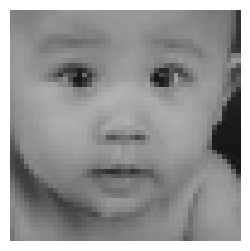

In [ ]:
# Let's print an image and it's label from train ds
for images, labels in train_ds:
    print('images.shape:', images.shape)
    plt.figure(figsize=(3,3))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=2).permute((1, 2, 0)))
    print(labels)
    break

In [ ]:
train_ds,val_ds=apply_transforms(train_ds,val_ds) # Applying transforms to datasets

# creating train and validation loaders
train_dl = create_dl(train_ds)  
valid_dl = create_dl(val_ds,val=True)

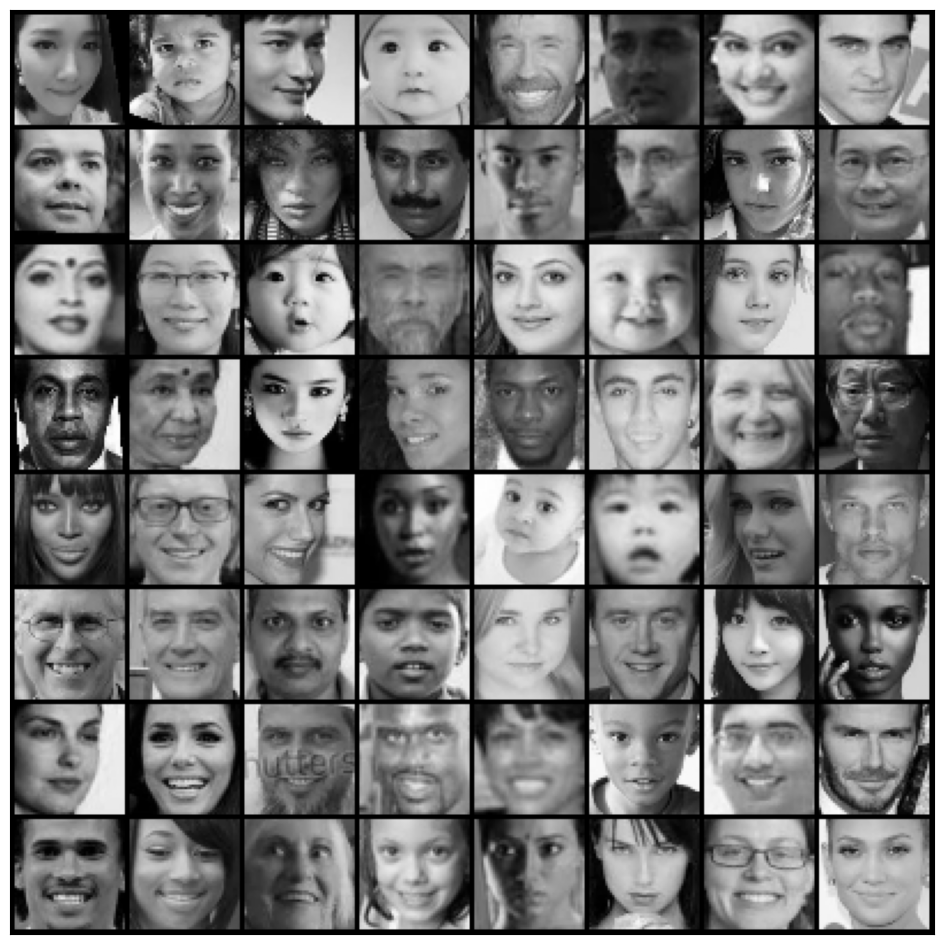

In [ ]:
#Let's take look at 1st batch of train data loader
show_batch(train_dl) 

In [ ]:
# Shifting Data Loaders to GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
# Extending our Base class and defining resnet9 architecture
class ResNet9(Base):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 200)
        self.conv2 = conv_block(200, 100, pool=True)
        self.res1 = nn.Sequential(conv_block(100,100), conv_block(100,100))
        
        self.conv3 = conv_block(100, 190, pool=True)
        self.conv4 = conv_block(190, 360, pool=True)
        self.res2 = nn.Sequential(conv_block(360, 360), conv_block(360, 360))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(360, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
# Shifting model to GPU
model = to_device(ResNet9(1, 10), device)
model # checking if everythin's fine with our model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(200, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace

In [ ]:
history = [evaluate(model, valid_dl)]
history


[{'val_loss': 2.305929183959961, 'val_acc': 0.030743202194571495}]

In [ ]:
%%time
epochs = 6
max_lr = 0.004
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.NAdam
history=[]
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00240, train_loss: 1.8622, val_loss: 1.9105, val_acc: 0.3946
Epoch [1], last_lr: 0.00398, train_loss: 1.3915, val_loss: 1.4366, val_acc: 0.5187
Epoch [2], last_lr: 0.00325, train_loss: 1.0562, val_loss: 0.9857, val_acc: 0.6650
Epoch [3], last_lr: 0.00185, train_loss: 0.8314, val_loss: 0.9048, val_acc: 0.6951
Epoch [4], last_lr: 0.00053, train_loss: 0.6182, val_loss: 0.7799, val_acc: 0.7357
Epoch [5], last_lr: 0.00000, train_loss: 0.4273, val_loss: 0.7763, val_acc: 0.7451
CPU times: user 1min 1s, sys: 55.1 s, total: 1min 56s
Wall time: 2min 5s


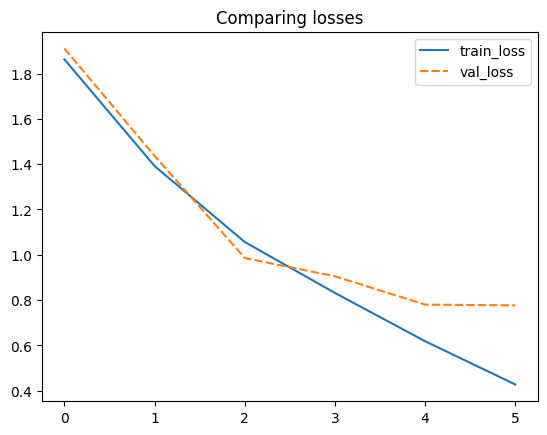

In [ ]:
history_df=pd.DataFrame(history)
sns.lineplot(data=history_df[['train_loss','val_loss']]).set(title='Comparing losses');

In [ ]:
preds_g=get_subclass_preds('gender',val_df,model=model)

Accuracy for gender 0 : 0.9008073817762399
Accuracy for gender 1 : 0.9134382566585957


In [ ]:
preds_e=get_subclass_preds('ethnicity',val_df,model=model)

Accuracy for ethnicity 0 : 0.853589196872779
Accuracy for ethnicity 1 : 0.8702865761689291
Accuracy for ethnicity 2 : 0.8936170212765957
Accuracy for ethnicity 3 : 0.7971781305114638
Accuracy for ethnicity 4 : 0.3706896551724138


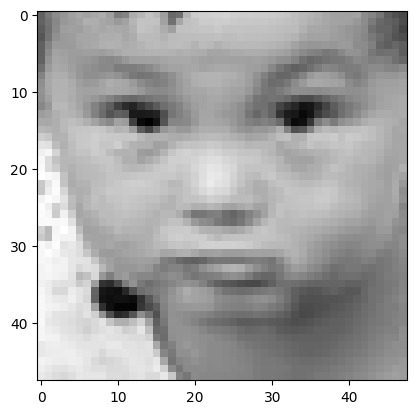

Label: tensor(2) , Predicted: [2]


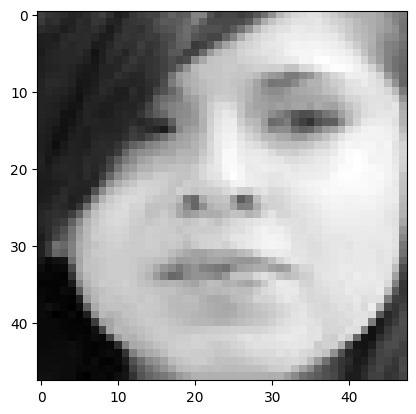

Label: tensor(15) , Predicted: [5]


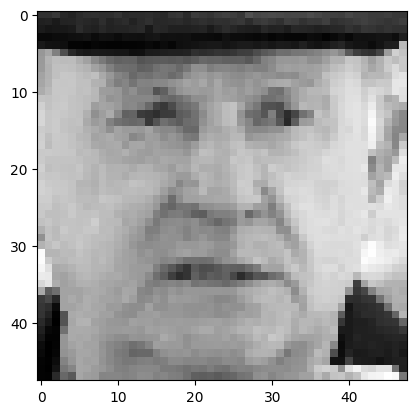

Label: tensor(67) , Predicted: [0]


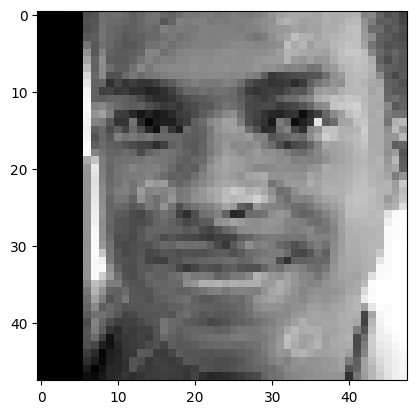

Label: tensor(32) , Predicted: [1]


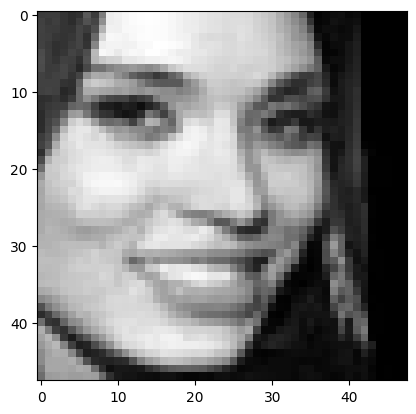

Label: tensor(26) , Predicted: [9]


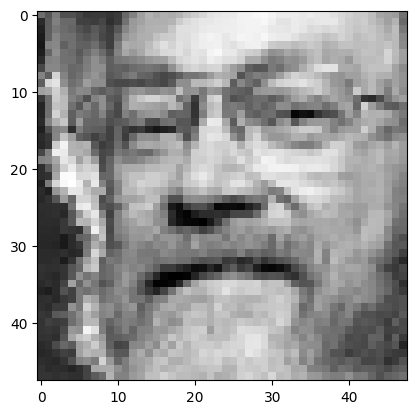

Label: tensor(60) , Predicted: [0]


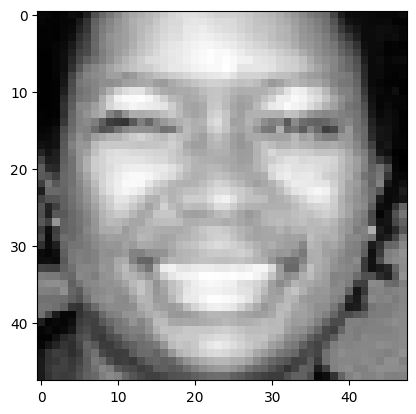

Label: tensor(28) , Predicted: [6]


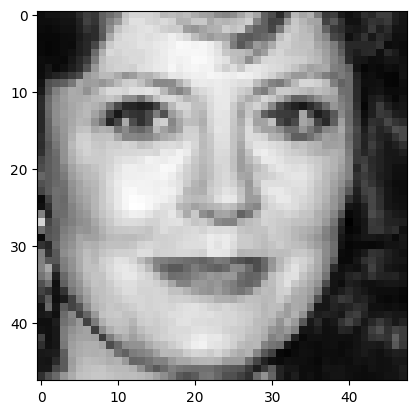

Label: tensor(65) , Predicted: [5]


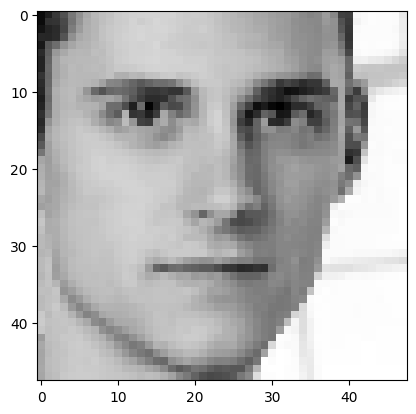

Label: tensor(17) , Predicted: [0]


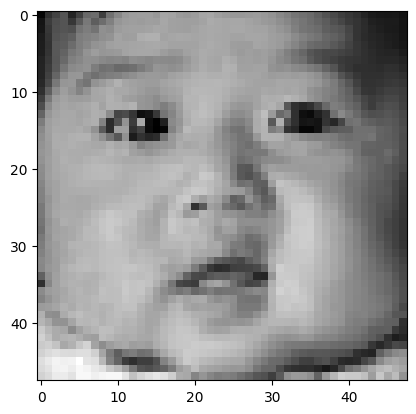

Label: tensor(1) , Predicted: [2]


In [ ]:
import random

for i in range(10):
    num1=random.randint(0,300)
    img, label = val_ds[num1]
    #ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
    plt.imshow(img.permute(1, 2, 0).clamp(0,1),cmap='gray')
    plt.show()
    print('Label:', val_ds[num1][1], ', Predicted:', predict_image(img, model))

In [ ]:
# Checking Value counts for all ages
Age_df=raw_df[['age']].value_counts()
Age_df=Age_df.reset_index()
Age_df.rename(columns = {0:'Value_counts'}, inplace = True)
Age_df

,age,Value_counts
0,26,2197
1,1,1123
2,28,918
3,35,880
4,24,859
...,...,...
99,115,3
100,91,2
101,101,2
102,103,1


In [ ]:
# Let's check the ranges
for _ in range(100,2300,100):
    print(f"From {_-100} to {_}  :",Age_df[(Age_df.Value_counts<_) & (Age_df.Value_counts>_-100)].shape[0])

From 0 to 100  : 40
From 100 to 200  : 24
From 200 to 300  : 16
From 300 to 400  : 6
From 400 to 500  : 5
From 500 to 600  : 2
From 600 to 700  : 2
From 700 to 800  : 2
From 800 to 900  : 2
From 900 to 1000  : 1
From 1000 to 1100  : 0
From 1100 to 1200  : 1
From 1200 to 1300  : 0
From 1300 to 1400  : 0
From 1400 to 1500  : 0
From 1500 to 1600  : 0
From 1600 to 1700  : 0
From 1700 to 1800  : 0
From 1800 to 1900  : 0
From 1900 to 2000  : 0
From 2000 to 2100  : 0
From 2100 to 2200  : 1


In [ ]:
px.histogram(raw_df,'age',title='Count of Images vs Age for raw_df')

In [ ]:
# We should consider dropping ages above 85
Age_df=raw_df[['age','pixels']]
Age_df=Age_df.query("age<86")

In [ ]:
#Checking if we have any missing age
All_ages=[x for x in range(1,81)]
Missing_ages=np.setdiff1d(All_ages,Age_df.age)
Missing_ages

array([], dtype=int64)

In [ ]:
# Separating ~ 15 % of data as validation set
x=len(Age_df)
val_df=Age_df.sample(x//7,random_state=40)

In [ ]:
# preparing training set
train_df=Age_df.copy()
train_df.drop(val_df.index,inplace=True)

In [ ]:
train_df.columns

Index(['age', 'pixels'], dtype='object')

In [ ]:
#undersampling operation
train_df.reset_index(drop=True)
train1_df = pd.DataFrame(columns=['age','pixels'])
for _ in train_df.age.unique():
    if len(train_df[train_df.age==_])>400:
        x=train_df[train_df.age==_].sample(400).copy()
        train1_df=pd.concat([train1_df, x], axis=0)
    else: 
        x=train_df[train_df.age==_].copy()
        train1_df=pd.concat([train1_df, x], axis=0)
        del x

In [ ]:
train_df.age=train_df.age-1
train1_df.age=train1_df.age-1

In [ ]:
px.histogram(train_df,'age',title='Count of Images vs Age (below 90)')

In [ ]:
px.histogram(train1_df,'age',title='Count of Images vs Age (below 90) after undersampling')

In [ ]:
#Converting to datasets
train_ds=create_ds(train_df,age=True)
val_ds=create_ds(val_df,age=True)
train1_ds=create_ds(train1_df,age=True)
val1_ds=create_ds(val_df,age=True)

images.shape: torch.Size([1, 48, 48])
tensor(0)


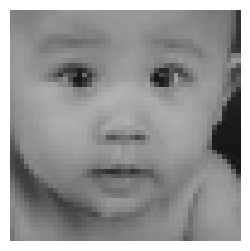

In [ ]:
for images, labels in train_ds:
    print('images.shape:', images.shape)
    plt.figure(figsize=(3,3))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=2).permute((1, 2, 0)))
    print(labels)
    break

In [ ]:
train_ds,val_ds=apply_transforms(train_ds,val_ds,train=True) # applying trnsforms
train1_ds,val1_ds=apply_transforms(train1_ds,val1_ds,train=True) # applying trnsforms

In [ ]:
# Creating Dataloaders and shifting them to GPU
train_dl=create_dl(train_ds,batch_size=100,val=False)
val_dl= create_dl(val_ds,batch_size=100,val=True) 
train1_dl=create_dl(train1_ds,batch_size=100,val=False)
val1_dl= create_dl(val1_ds,batch_size=100,val=True) 

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
train1_dl = DeviceDataLoader(train1_dl, device)
val1_dl = DeviceDataLoader(val1_dl, device)

In [ ]:
class ResNet18(Base):
    def __init__(self, in_channels):
        super().__init__()
        self.conv0=conv_block(in_channels, 64)
        self.res0=nn.Sequential(conv_block(64,64), conv_block(64,64))
        self.res1 = nn.Sequential(conv_block(64,64), conv_block(64,64))
        self.conv1 = conv_block(64, 128)
        self.conv2 = conv_block(128, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256,256), conv_block(256,256))
        
        self.conv3 = conv_block(256, 450)
        self.conv4 = conv_block(450, 512,pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        #self.dense_out = nn.Linear(in_features=hidden_size, out_features=1)
        
        self.conv5 = conv_block(512, 72)
        self.conv6 = conv_block(72, 250,pool=True)
        self.res4 = nn.Sequential(conv_block(250,250), conv_block(250,250))
        
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(250, 1))
        
    def forward(self, xb):
        out = self.conv0(xb)
        out = self.res0(out) + out
        out = self.res1(out) + out
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res3(out) + out
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res4(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model2 = to_device(ResNet18(1), device)
model2

ResNet18(
  (conv0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res0): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, ke

In [ ]:
model21 = to_device(ResNet18(1), device)
model21

ResNet18(
  (conv0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res0): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, ke

In [ ]:
history = [evaluate(model2, val_dl,age=True)]
history

[{'val_loss': 38.02312088012695}]

In [ ]:
%%time
epochs = 6
max_lr = 0.0005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history=[]
history += fit_one_cycle(epochs, max_lr, model2, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func,age=True)
# was for less than 70 age no under sampling

Epoch [0], last_lr: 0.00030, train_loss: 17.7983, val_loss: 13.4916
Epoch [1], last_lr: 0.00050, train_loss: 10.5731, val_loss: 10.5420
Epoch [2], last_lr: 0.00041, train_loss: 9.1097, val_loss: 8.5019
Epoch [3], last_lr: 0.00023, train_loss: 8.0298, val_loss: 7.9061
Epoch [4], last_lr: 0.00007, train_loss: 6.8394, val_loss: 7.7303
Epoch [5], last_lr: 0.00000, train_loss: 5.6432, val_loss: 7.7949
CPU times: user 3min 59s, sys: 4min 13s, total: 8min 12s
Wall time: 8min 19s


In [ ]:
get_subclass_age_rmse(val_df,model2,20)

RMSE for age group 0 to 20 : {'val_loss': 6.220362663269043}
Accuracy for age group 0 to 20 : 0.78
RMSE for age group 20 to 40 : {'val_loss': 5.98954439163208}
Accuracy for age group 20 to 40 : 0.89
RMSE for age group 40 to 60 : {'val_loss': 9.983373641967773}
Accuracy for age group 40 to 60 : 0.57
RMSE for age group 60 to 80 : {'val_loss': 11.925130844116211}
Accuracy for age group 60 to 80 : 0.55
RMSE for age group 80 to 100 : {'val_loss': 16.498708724975586}
Accuracy for age group 80 to 100 : 0.16


In [ ]:
model21 = to_device(ResNet18(1), device)

In [ ]:
history1 = [evaluate(model21, val1_dl,age=True)]
history1

[{'val_loss': 38.05709457397461}]

In [ ]:
%%time
epochs = 4
max_lr = 0.0004
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.NAdam
history1=[]
history1 += fit_one_cycle(epochs, max_lr, model21, train1_dl, val1_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func,age=True)
# with under sampling

Epoch [0], last_lr: 0.00037, train_loss: 18.2280, val_loss: 11.6620
Epoch [1], last_lr: 0.00032, train_loss: 10.9824, val_loss: 10.7224
Epoch [2], last_lr: 0.00011, train_loss: 8.7973, val_loss: 8.6987
Epoch [3], last_lr: 0.00000, train_loss: 7.0212, val_loss: 8.0683
CPU times: user 2min 11s, sys: 2min 17s, total: 4min 28s
Wall time: 4min 32s


In [ ]:
get_subclass_age_rmse(val_df,model21,20)

RMSE for age group 0 to 20 : {'val_loss': 6.583382606506348}
Accuracy for age group 0 to 20 : 0.81
RMSE for age group 20 to 40 : {'val_loss': 6.485769271850586}
Accuracy for age group 20 to 40 : 0.85
RMSE for age group 40 to 60 : {'val_loss': 9.88938045501709}
Accuracy for age group 40 to 60 : 0.6
RMSE for age group 60 to 80 : {'val_loss': 12.394126892089844}
Accuracy for age group 60 to 80 : 0.5
RMSE for age group 80 to 100 : {'val_loss': 16.645357131958008}
Accuracy for age group 80 to 100 : 0.16


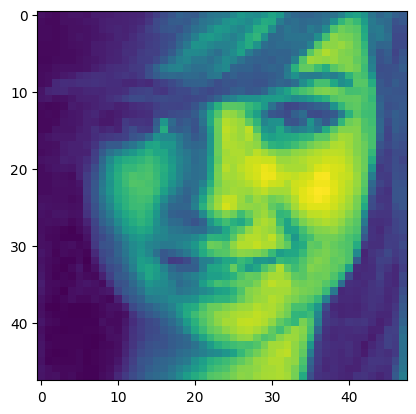

Label: 17 , Predicted: 19.75


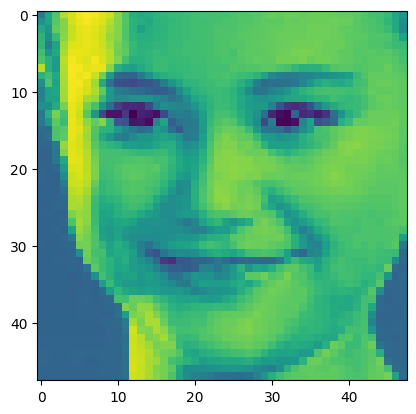

Label: 10 , Predicted: 17.52


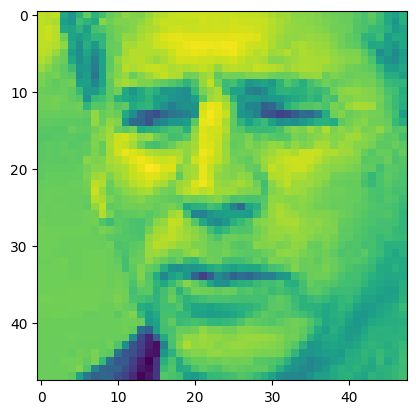

Label: 47 , Predicted: 55.4


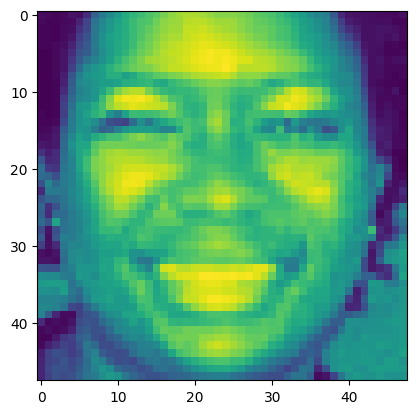

Label: 28 , Predicted: 29.61


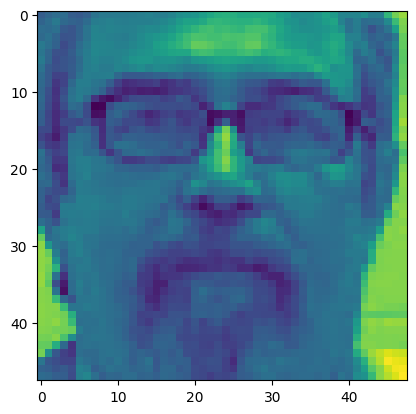

Label: 54 , Predicted: 51.0


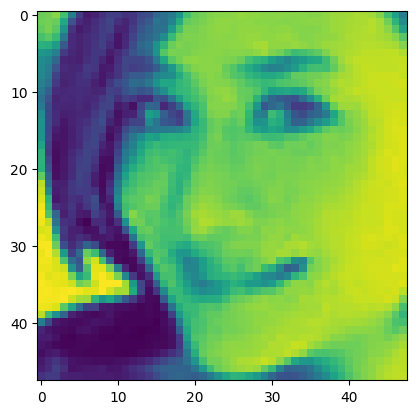

Label: 30 , Predicted: 25.47


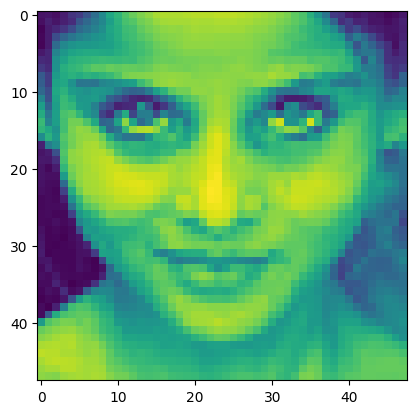

Label: 14 , Predicted: 10.5


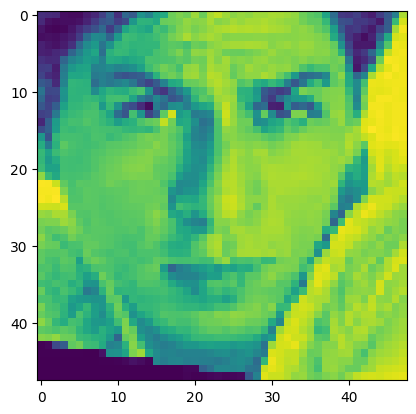

Label: 32 , Predicted: 22.99


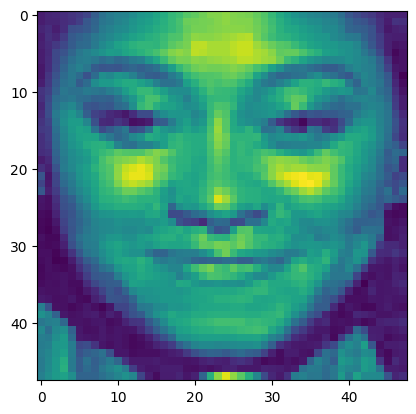

Label: 26 , Predicted: 27.93


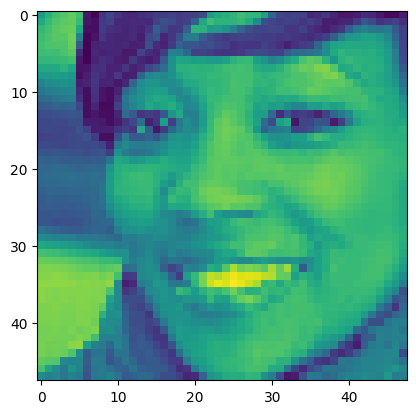

Label: 26 , Predicted: 18.56


In [ ]:
import random

for i in range(10):
    num1=random.randint(0,700)
    img, label = val_ds[num1]
   # ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
    plt.imshow(img.permute(1, 2, 0).clamp(0,1))
    plt.show()
    pred=predict_image(img, model21,age=True)
    pred=pred.detach()
    print('Label:', val_ds[num1][1].item(), ', Predicted:',round(pred.item(),2))

In [ ]:
import cv2
import torchvision.transforms as transforms
def predict_image_custom(image_path):
  img = cv2.imread(image_path, 0)
  img = cv2.resize(img, (48,48))
  #print(img)
  img = img/255
  img = img.astype(np.float32)
  transform = transforms.ToTensor()
  img = transform(img)
  pred_GE=predict_image(img, model)
  pred_age = predict_image(img, model21, age = True)
  pred_age=pred_age.detach()
  print(pred_GE, round(pred_age.item(),2))

predict_image_custom('virat.jpg')

[0] 23.07


In [ ]:
predict_image_custom('white.jpg')

[2] 59.69


In [ ]:
predict_image_custom('chinese.jpg')

[6] 30.47


In [ ]:
predict_image_custom('morgan.jpg')

[1] 36.0


In [ ]:
predict_image_custom('baby.webp')

[[ 76  74 121 ... 168 156 111]
 [ 63  84 142 ... 164 160 127]
 [ 72 109 154 ... 177 158 120]
 ...
 [201 201 206 ... 168 165 162]
 [204 202 204 ... 169 169 163]
 [204 205 206 ... 173 173 169]]
[2] 3.38


In [ ]:
predict_image_custom('baby2.jpg')

[8] 19.64


In [ ]:
predict_image_custom('chandler.jpg')

[0] 41.61


In [ ]:
predict_image_custom('srk.jpg')

[2] 27.86


In [ ]:
predict_image_custom('moid.webp')

[1] 30.99


In [ ]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
with open('model21.pkl', 'wb') as file:
    pickle.dump(model21, file)

In [ ]:
import torch
import torch.nn as nn

# Assuming you have a PyTorch ResNet model named 'resnet_model'
torch.save(model.state_dict(), 'weights.pth')
torch.save(model, 'model.pth')

In [ ]:
torch.save(model21.state_dict(), 'weights21.pth')
torch.save(model21, 'model21.pth')